In [1]:
import random as rd
import astropy.io.fits as apf
import batman
import eleanor
import emcee
import getpass
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.backends.backend_pdf import PdfPages
# from multiprocessing import Pool
# from multiprocessing import Process
import multiprocessing
import numpy as np
import os
import pandas as pd
import shutil
import time as tm
from astroquery.mast import Catalogs
import astropy.units as units
from astropy.wcs import WCS
import math
import astropy.io.fits as apf
from astropy.stats import sigma_clip
import warnings
warnings.filterwarnings("ignore")
from wotan import flatten
import lightkurve as lk
import corner
import numpy as np
import juliet
import matplotlib.gridspec as gridspec

from astropy.timeseries import BoxLeastSquares
from ldtk import LDPSetCreator, BoxcarFilter, TabulatedFilter, SVOFilter
from ldtk.filters import tess, sdss_z
from astroquery import svo_fps

import mr_forecast as mr
import numba
from math import floor
from functools import partial


In [2]:
"""I'm going to go ahead and outline the steps to take:
1) Define output and input directories 
2) Check to see if you have already started your search, and if so get the times in transit AND TICIDs/GAIAids
3) Detrend data with wotan
3) Get outliers for each target and create a histogram of frequent outline points. Mask them. 
4) Save new flux+time data in fits file (if you can)
5) Before beginning SNR search: 
    a) calculate CDPP
    b) create SNR grid, getting min rp and duration
    c) calc limb darkening (?)
6) begin SNR search
    a) using """

"I'm going to go ahead and outline the steps to take:\n1) Define output and input directories \n2) Check to see if you have already started your search, and if so get the times in transit AND TICIDs/GAIAids\n3) Detrend data with wotan\n3) Get outliers for each target and create a histogram of frequent outline points. Mask them. \n4) Save new flux+time data in fits file (if you can)\n5) Before beginning SNR search: \n    a) calculate CDPP\n    b) create SNR grid, getting min rp and duration\n    c) calc limb darkening (?)\n6) begin SNR search\n    a) using "

In [3]:
RP_REFERENCE = 0.05

In [4]:
"""Let's start the following cells pretending that I have 
1) detrended data
2) sliced the LC
3) run the periodic search and masked out periodic transits
4) gotten a df including M_star, R_star, Teff_star, aLDC, bLDC"""




@numba.jit(nopython=True)
def interpolation_search(x, z):
    n = len(x)
#     print(n)
    assert n > 1
    if z < x[1] or n == 2:
        return 0
    elif z >= x[-2]:
        return n - 2
    imin = 0
    imax = n - 1
    while imax - imin > 1:
        s = (z - x[imin]) / (x[imax] - x[imin])
        j = int(imin + floor((imax - imin) * s))
        if z >= x[j + 1]:
            imin = j + 1
        elif z < x[j]:
            imax = j
        else:
            return j
    return imin


@numba.jit(nopython=True)
def lerp(y, theta):
    return (1 - theta) * y[..., 0] + theta * y[..., 1]


class interp1d(object):
    """
    Adapted from:
    Fast multithreaded linear interpolation, 1D and 2D - Ver. 3.4
    This versione: 15/06/2018
    @author: Marco Maffezzoli, Universita Bocconi
    http://didattica.unibocconi.it/mypage/upload/49183_20180615_035144_INTERPOLATION.PY
    """

    def __init__(self, x_new, x):
        (self._index, self._theta) = self._locate(x_new, x)
        
    @staticmethod
    @numba.guvectorize("(i8[:],f8[:],f8[:],f8[:])", "(m),(m),(n)->(m)")
    def _linear(index, theta, y, y_new):
        for (j, (i, t)) in enumerate(zip(index, theta)):
            y_new[j] = lerp(y[i : i + 2], t)

    def __call__(self, y):
        return self._linear(self._index, self._theta, y)

    @numba.guvectorize("(f8[:],f8[:],i8[:],f8[:])", "(),(n)->(),()")
    def _locate(x_new, x, index, theta =[]):
        index[0] = i = interpolation_search(x, x_new[0])
        theta[0] = (x_new[0] - x[i]) / (x[i + 1] - x[i])

In [5]:
TICIDs_to_try = [70899085,
150428135,
219175972,
259377017,
259377017,
307210830,
307210830]




In [6]:
###DEFAULTS

DURATIONS = np.array(range(2, 25))*30.
MAXWIDTH_IN_SAMPLES = 24
len(DURATIONS)
RP_REFERENCE = 0.05
T0_FIT_MARGIN = 0.01
TRANSIT_DEPTH_MIN = 2.5 * 10 ** -6  # 10 ppm
SIGNAL_DEPTH = 0.5


In [7]:
(1/109.076/0.37)**2 * ( 10 ** 6)

613.9572686602263

In [8]:
epochs_big = np.array(list(range(-500, 500)))


Toi904_Tdur_p1 = 2.90770240441174
Toi904_T0_p1   = 2459366.628641-2457000
Toi904_per_p1  = 10.877
epochs_Toi904_p1   = Toi904_T0_p1+(epochs_big*Toi904_per_p1)

Toi904_Tdur_p2 = 5.081
Toi904_T0_p2   = 2459386.3-2457000
Toi904_per_p2  =83.9996075
epochs_Toi904_p2   = Toi904_T0_p2+(epochs_big*Toi904_per_p2)


Toi904_Tdur = [Toi904_Tdur_p1, Toi904_Tdur_p2]#, Toi904_Tdur_p4]
Toi904_T0 = [Toi904_T0_p1, Toi904_T0_p2]#, Toi904_T0_p4]
Toi904_per = [Toi904_per_p1, Toi904_per_p2]#, Toi904_per_p4]

epochs_Toi904 = [epochs_Toi904_p1, epochs_Toi904_p2]#, epochs_Toi904_p4]

In [9]:
# TICID = 259377017
# Toi270_Tdur_p1 = 1.66317
# Toi270_T0_p1   = 2198.96
# Toi270_per_p1  = 5.66057
# epochs_Toi270_p1   = Toi270_T0_p1+(epochs_big*Toi270_per_p1)

# Toi270_Tdur_p2 = 2.23503
# Toi270_T0_p2   = 1389.68
# Toi270_per_p2  = 11.3796
# epochs_Toi270_p2   = Toi270_T0_p2+(epochs_big*Toi270_per_p2)

# Toi270_Tdur_p3 = 1.41324
# Toi270_T0_p3   = 1383.73
# Toi270_per_p3  = 3.36014
# epochs_Toi270_p3   = Toi270_T0_p3+(epochs_big*Toi270_per_p3)


# # Toi270_Tdur_p4 = 3.2838
# # Toi270_T0_p4   = 1352.99
# # Toi270_per_p4  = 27.8094
# # epochs_Toi270_p4   =Toi270_T0_p4+(epochs_big*Toi270_per_p4)

# Toi270_Tdur = [Toi270_Tdur_p1, Toi270_Tdur_p2, Toi270_Tdur_p3]#, Toi270_Tdur_p4]
# Toi270_T0 = [Toi270_T0_p1, Toi270_T0_p2, Toi270_T0_p3]#, Toi270_T0_p4]
# Toi270_per = [Toi270_per_p1, Toi270_per_p2, Toi270_per_p3]#, Toi270_per_p4]

# epochs_Toi270 = [epochs_Toi270_p1, epochs_Toi270_p2, epochs_Toi270_p3]#, epochs_Toi270_p4]

In [10]:
ctlfile = './Total_Mdwarf_files/by_sector/PM_year_1/mdwarf_params_sector_13.csv'
mdwarfs = pd.read_csv(ctlfile, iterator =True, chunksize = 100000, index_col=0)

TOI_904 = pd.concat(
    [chunk[chunk['TICID'].astype(int)==int(261257684)] 
    for chunk in mdwarfs]
).reset_index(drop=True)

In [11]:
TOI_904

,TICID,RA,DEC,Vmag,Jmag,Tmag,Teff,eTeff,Rad,eRad,...,S53,S54,S55,logg,elogg,M/H,eM/H,GAIA,aLSM,bLSM
0,261257684.0,89.372315,-83.130204,12.588,9.607,10.846,3751.0,157.0,0.532439,0.015794,...,0.0,0.0,0.0,4.70914,0.009127,NaN,NaN,4.620844e+18,0.2581,0.3609


In [12]:
def fractional_transit(
    duration,
    maxwidth,
    depth,
    samples,
    per,
    rp,
    a,
    inc,
    ecc,
    w,
    u,
    limb_dark,
    cached_reference_transit=None,
):
    """Returns a scaled reference transit with fractional width and depth"""

    if cached_reference_transit is None:
#         print('a')
        reference_flux = reference_transit(
            samples=samples,
            per=per,
            rp=rp,
            a=a,
            inc=inc,
            ecc=ecc,
            w=w,
            u=u,
            limb_dark=limb_dark,
        )
    else:
#         print('b')
        reference_flux = cached_reference_transit

    # Interpolate to shorter interval - new method without scipy
    reference_time = np.linspace(-0.5, 0.5, samples)
    occupied_samples = int((duration / maxwidth) * samples)
    x_new = np.linspace(-0.5, 0.5, occupied_samples)
#     print(type(x_new),type(x_new[0]), type(reference_time), type(reference_time[0]))
    f = interp1d(x_new, reference_time)
#     print(type(reference_flux), type(reference_flux[0]))
    y_new = f(reference_flux)

    # Patch ends with ones ("1")
    missing_samples = samples - occupied_samples
    emtpy_segment = np.ones(int(missing_samples * 0.5))
    result = np.append(emtpy_segment, y_new)
    result = np.append(result, emtpy_segment)
#     print(len(result), len(reference_time))
    if np.size(result) < samples:  # If odd number of samples
        result = np.append(result, np.ones(1))

    # Depth rescaling
    result = 1 - ((1 - result) * depth)
#     print(duration)
#     plt.plot(np.linspace(min(reference_time), max(reference_time), len(result)), result)
#     plt.show()

    return result

###Creating cache of models
def reference_transit(per, rp, a, inc, ecc, w, u, limb_dark, samples = 24):
    """Returns an Earth-like transit of width 1 and depth 1"""
    ###Samples = maxwidth of samples = number of points in max duration val
    ###NOTE: TLS requires that his number be EVEN
    f = np.ones(1000)
    duration = 1  # transit duration in days. Increase for exotic cases. ###I want the max trans dur to be 12 hrs
    t = np.linspace(-duration * 0.5, duration * 0.5, 1000)
    t_2_lin = np.linspace(0., duration, 1000)
    ###FOR ME: T=time in lc <- NOT TRUE. WHY: this is a model. I would like each transit 
    ###to start at 0 and then go to x duration BECAUSE ising t0 = 0 is EASY and then i
    ###will SHIFT IT so the transit starts at 0 and t0 is size of shift 
    b_model           = batman.TransitParams()
    b_model.t0        = 0  # time of inferior conjunction
    b_model.per       = per  # orbital period, use Earth as a reference
    b_model.rp        = rp  # planet radius (in units of stellar radii)
    b_model.a         = a  # semi-major axis (in units of stellar radii)
    b_model.inc       = inc  # orbital inclination (in degrees)
    b_model.ecc       = ecc  # eccentricity
    b_model.w         = w  # longitude of periastron (in degrees)
    b_model.u         = u  # limb darkening coefficients
    b_model.limb_dark = limb_dark  # limb darkening model
    m = batman.TransitModel(b_model, t)  # initializes model
    model_flux = m.light_curve(b_model)  # calculates light curve

    # Determine start of transit (first value < 1)
    idx_first = np.argmax(model_flux < 1)
#     print(idx_first, len(model_flux))
    intransit_model_flux = model_flux[idx_first : -idx_first + 1]
    intransit_time = t[idx_first : -idx_first + 1] 

    # Downsample (bin) to target sample size
    x_new = np.linspace(t[idx_first], t[-idx_first - 1], samples)
#     print(type(x_new),type(x_new[0]), type(intransit_time), type(intransit_time[0]))

    f = interp1d(x_new, intransit_time)
#     print(type(intransit_model_flux), type(intransit_model_flux[0]))
    downsampled_intransit_model_flux = f(intransit_model_flux)

    # Rescale to height [0..1]
    rescaled = (np.min(downsampled_intransit_model_flux) - downsampled_intransit_model_flux) / (
        np.min(downsampled_intransit_model_flux) - 1
    )
    
#     plt.plot(np.linspace(min(intransit_time), max(intransit_time), len(rescaled)), rescaled)
#     plt.show()
    return rescaled #, intransit_time


def get_cache(durations, rp = 0.03, per=25., a =0.15*215., inc=89.5, ecc=0., w=180., u=[0.2, 0.1],
              limb_dark='quadratic', verbose=True, maxwidth_in_samples = MAXWIDTH_IN_SAMPLES):
    """Fetches (size(durations)*size(depths)) light curves of length 
        maxwidth_in_samples and returns these LCs in a 2D array, together with 
        their metadata in a separate array."""
    
    if verbose:
        print("Creating model cache for", str(len(durations)), "durations")
    lc_arr = []
    rows = np.size(durations)
    lc_cache_overview = np.zeros(
        rows,
        dtype=[("duration", "float128"), ("width_in_samples", "int64"), ("overshoot", "float128")],
    )
    cached_reference_transit = reference_transit(
#         samples=maxwidth_in_samples,
        per=per,
        rp=rp,
        a=a,
        inc=inc,
        ecc=ecc,
        w=w,
        u=u,
        limb_dark=limb_dark,
    )

    row = 0
    for duration in durations:
        scaled_transit = fractional_transit(
            duration=duration,
            maxwidth=np.max(durations),
            depth=SIGNAL_DEPTH,
            samples=maxwidth_in_samples,
            per=per,
            rp=rp,
            a=a,
            inc=inc,
            ecc=ecc,
            w=w,
            u=u,
            limb_dark=limb_dark,
            cached_reference_transit=cached_reference_transit,
        )
        lc_cache_overview["duration"][row] = duration
        used_samples = int((duration / np.max(durations)) * maxwidth_in_samples)
        lc_cache_overview["width_in_samples"][row] = used_samples
        full_values = np.where(
            scaled_transit < (1 - 0.01 * 10 ** -6 )
        )
#         print(scaled_transit < (1 - 0.01 * 10 ** -6 ))
        first_sample = np.min(full_values)
        last_sample = np.max(full_values) + 1
        signal = scaled_transit[first_sample:last_sample]
        lc_arr.append(signal)

        # Fraction of transit bottom and mean flux
        overshoot = np.mean(signal) / np.min(signal)
        # Later, we multiply the inverse fraction ==> convert to inverse percentage
        lc_cache_overview["overshoot"][row] = 1 / (2 - overshoot)
#         print(overshoot, 1 / (2 - overshoot))
        row += +1
        

    lc_arr = np.array(lc_arr, dtype=object)
    return lc_cache_overview, lc_arr


In [13]:
list_=np.zeros(10)
residuals = np.full(len(list_), np.nan, dtype=[('chi2','object')])
residuals

array([(nan,), (nan,), (nan,), (nan,), (nan,), (nan,), (nan,), (nan,),
       (nan,), (nan,)], dtype=[('chi2', 'O')])

In [14]:
# T0_p1 = 2459366.628641-2457000

# p_p1 = 10.877 #period

# T0_p2 = 2459386.3-2457000
# # T0_p2 = 2387.2
# p_p2 = 83.9996075 #period

# epochs = np.array(list(range(-30, 20)))
# epochs_T0_p2 = T0_p2+(epochs*p_p2)
epochs_big = np.array(list(range(-500, 500)))

# epochs_T0_p1 = T0_p1+(epochs_big*p_p1)



# @numba.jit(fastmath=True, parallel=False, nopython=True)
def lowest_residuals_in_this_duration(
    mean,
    time,
    transit_depth_min,
    data_arr,
    duration,
    signal,
    inverse_squared_dy_arr,
    overshoot,
    ootr,
    chosen_transit_row,
    datapoints,
    T0_fit_margin, 
    threshold = 7.3, 
    verbose = False
):
    T0 = []
    T0_st_indx = []
    SNR = threshold
    residuals_depths = np.full(len(time), np.nan, dtype = ([("residuals", "float128"), ("depths", "float128")]))
    # if nothing is fit, we fit a straight line: signal=1. Then, at dy=1,
    # the squared sum of residuals equals the number of datapoints
    summed_residual_in_rows = datapoints

    xth_point = 1  # How many cadences the template shifts forward in each step
    if T0_fit_margin > 0 and duration > T0_fit_margin:
        T0_fit_margin = 1 / T0_fit_margin
        xth_point = int(duration / T0_fit_margin)
        if xth_point < 1:
            xth_point = 1

    for i in range(len(mean)):
        if (mean[i] > transit_depth_min) and (i % xth_point == 0):
            data = data_arr[i : i + duration]
            flux_oot = np.delete(data_arr, range(i,i+duration))

            dy = inverse_squared_dy_arr[i : i + duration]
            target_depth = mean[i] * overshoot
            scale = SIGNAL_DEPTH / target_depth
            reverse_scale = 1 / scale  # speed: one division now, many mults later
            snr = (mean[i] / (np.std(flux_oot)*np.sqrt(0.5))) * duration ** (0.5)
            if snr>SNR:
                SNR=snr
            intransit_residual = 0
            for j in range(len(signal)):
                sigi = (1 - signal[j]) * reverse_scale
                intransit_residual += ((data[j] - (1 - sigi)) ** 2) * dy[j]
            current_stat = intransit_residual + ootr[i] #- summed_edge_effect_correction
            
            residuals_depths['residuals'][i] = current_stat
            residuals_depths['depths'][i] = 1-target_depth
            
    residuals = residuals_depths['residuals'].astype('float128')

    if np.nanmin(residuals)<=np.nanmedian(residuals)-4*np.nanstd(residuals) and SNR>threshold:
        indexes = np.where(residuals<=np.nanmedian(residuals)-4*np.nanstd(residuals))[0]
        for jjj in indexes:
            if jjj and jjj+1 in indexes:
                T0_st_indx.extend(np.where(residuals == min(residuals[[jjj, jjj+1]]))[0])
        
        if verbose:
            print(duration*30/60, 'planets Tdur: ', Toi904_Tdur)#' Tdur_p4:', Toi904_Tdur[3])
            fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(20,5))
            axes[0].plot(time, residuals, zorder = 10)

            axes[1].scatter(time, data_arr, s = 1, zorder = 11, alpha = 1, color = 'black')
#             for rrr in range(len(epochs_new)):
#                 for i in epochs_new[rrr]:
#                     diff = np.nanmax(residuals)-np.nanmin(residuals)
#                     axes[0].vlines(i-(Toi904_Tdur[rrr]/48), np.nanmin(residuals),np.nanmax(residuals), color = 'C'+str(rrr), alpha = 0.5, zorder = 2)
#                     axes[1].vlines(i, np.nanmin(data_arr),np.nanmax(data_arr), color = 'C'+str(rrr), alpha = 0.5, zorder = 2)
            for j in range(1,7):
                axes[0].hlines(np.nanmedian(residuals)-j*np.nanstd(residuals), np.min(time), np.max(time), alpha = 0.5, zorder = 3, color = 'violet')
            plt.subplots_adjust(wspace=0.2, hspace=0)
            plt.show()

    
        return SNR, np.array(list(residuals_depths['residuals'].astype('float128'))), np.array(list(residuals_depths['depths'].astype('float128'))), T0_st_indx
    else:
        return 0, [],[], []
    
    

In [15]:
# @numba.jit(fastmath=True, parallel=False, nopython=True)
def out_of_transit_residuals(data, width_signal, inv_sq_dy):
    chi2 = np.zeros(len(data) - width_signal + 1)
    fullsum = np.sum(((1 - data) ** 2) * inv_sq_dy)
    window = np.sum(((1 - data[:width_signal]) ** 2) * inv_sq_dy[:width_signal])
    chi2[0] = fullsum - window
    for i in range(1, len(data) - width_signal + 1):
        becomes_visible = i - 1
        becomes_invisible = i - 1 + width_signal
        add_visible_left = (1 - data[becomes_visible]) ** 2 * inv_sq_dy[becomes_visible]
        remove_invisible_right = (1 - data[becomes_invisible]) ** 2 * inv_sq_dy[
            becomes_invisible
        ]
        chi2[i] = chi2[i - 1] + add_visible_left - remove_invisible_right
    return chi2


In [16]:
# thing = np.zeros(
#         12,
#         dtype=[("duration_pts", "int64"), ("residuals", "object")],
#     )
# thing[0][1] = [1,2,3]
# thing[1][1] = [4,5,6]
# for i in range(2, 12):
#     thing[i][1] = [100, 200, 300]

# x = np.array([[1],[10]], dtype=[('thing', 'float128'), ('stuff', 'float128')])
# x

# stack_y = np.arrafy([4,40])

# np.column_stack((x, stack_y))


In [17]:
dict_t0 = {}
dict_t0['index_val']= 10
dict_t0
if 'a' not in dict_t0.keys():
    dict_t0['a'] = 10
dict_t0

{'index_val': 10, 'a': 10}

In [18]:
T0_vals = np.zeros(
        0,
        dtype=[('T0', 'float128'), ('best_dur', 'int64'), ('best_depth', 'float128')],
    )
T0_vals

array([],
      dtype=[('T0', '<f16'), ('best_dur', '<i8'), ('best_depth', '<f16')])

In [19]:
T0_vals = np.ones(
        10,
        dtype=[('T0', 'float128'), ('best_dur', 'int64')],
    )
T0_vals['T0'][4]=5
T0_vals[np.where(T0_vals['T0']==5)[0][False]] = 3


In [20]:
T0_vals

array([(1., 1), (1., 1), (1., 1), (1., 1), (5., 1), (1., 1), (1., 1),
       (1., 1), (1., 1), (1., 1)],
      dtype=[('T0', '<f16'), ('best_dur', '<i8')])

In [21]:
T0_vals = np.full(
    100, np.nan, 
    dtype=[('T0_start', 'int64'), ('T0', 'float128'), ('residuals', 'float128'), ('best_dur', 'int64'), ('best_depth', 'float128')]
)

T0_vals['T0_start'][10] = 100

min(np.where(T0_vals['best_dur']==-9223372036854775808)[0])


0

In [22]:
np.where(T0_vals['T0_start']==50)[0]

array([], dtype=int64)

In [23]:
def search_best_fit_duration(
#     duration,
    t,
    y,
    dy,
    transit_depth_min,
    lc_arr,
    lc_cache_overview,
    T0_fit_margin,
    verbose = True
):
    """Core routine to search the flux data set 'injected' over all 'periods'"""
    SNR_val = 0.

    # duration (in samples) of widest transit in lc_cache (axis 0: rows; axis 1: columns)
    npoints_in_duration = np.unique(lc_cache_overview["width_in_samples"])
    T0_vals = np.full(
        100, np.nan, 
        dtype=[('T0_start', 'float128'), ('T0', 'float128'), ('residuals', 'float128'), ('best_dur', 'int64'), ('best_depth', 'float128')]
    )

#     maxwidth_in_samples = int(max(npoints_in_duration))
#     if maxwidth_in_samples % 2 != 0:
#         maxwidth_in_samples = maxwidth_in_samples + 1

    inverse_squared_dy = 1 / dy ** 2

    skipped_all = True
#     best_row = 0  # shortest and shallowest transit
#     best_depth = 0
    T0_starts = []
    for i in range(len(npoints_in_duration)):
        dur = npoints_in_duration[i]

        chosen_transit_row = 0
        while lc_cache_overview["width_in_samples"][chosen_transit_row] != dur:
            chosen_transit_row += 1
        snr, residuals, depths, T0_start_indx = lowest_residuals_in_this_duration(
            mean=1 - running_mean(y, dur),
            time = t,
            transit_depth_min=transit_depth_min,
            data_arr=y,
            duration=dur,
            signal=lc_arr[chosen_transit_row],
            inverse_squared_dy_arr=inverse_squared_dy,
            overshoot=lc_cache_overview["overshoot"][chosen_transit_row],
            ootr=out_of_transit_residuals(
                y, dur, inverse_squared_dy
            ),
            chosen_transit_row=chosen_transit_row,
            datapoints=len(y),
            T0_fit_margin=T0_fit_margin,
        )
        
       
        SNR_val += snr
#         print('abc', len(residuals))
        residuals = residuals/np.nanmedian(residuals)
#         print('xyz', len(residuals))        

        T0_starts.extend(T0_start_indx)
        T0_starts = list(set(T0_starts))
#         print(T0_starts)
#         print('T0', T0_starts, T0_vals[np.where(T0_vals['T0_start']>0.)[0]], len(residuals))
        if len(residuals)>0:
            for jjj in T0_starts:
                indx = False
                try: 

                    indx = np.where(T0_vals['T0_start']==jjj)[0][0]
                    if float(T0_vals['residuals'][indx])<float(residuals[jjj]):
                        indx = False
#                     print('indx1')

                except:
#                     print('indx2')
                    indx = min(np.where(T0_vals['best_dur']==-9223372036854775808)[0])

#                 print(jjj, T0_vals['residuals'][indx])

                T0_vals['T0_start'][indx]   = jjj
                T0_vals['T0'][indx]         = t[jjj]+chosen_transit_row/48
                T0_vals['residuals'][indx]  = float(residuals[jjj])
                T0_vals['best_dur'][indx]   = chosen_transit_row
                T0_vals['best_depth'][indx] = float(depths[jjj])

        if verbose:
            f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize = (20, 10))

            resids = np.full(len(t), 0.0)

            for i in range(len(Residuals_all)):
        #         print(i)
                ax1.plot(t, Residuals_all[i], color = 'C'+str(i))
                resids = resids+(Residuals_all[i]-1)
            ax2.plot(t, resids, color = 'k' )
            plt.show()
    return np.array(list(T0_vals['T0_start'])), np.array(list(T0_vals['T0'])), np.array(list(T0_vals['best_dur'])), np.array(list(T0_vals['best_depth'])), np.array(list(T0_vals['residuals']))

        
        
# for i in residuals
#         if this_residual < summed_residual_in_rows:
#             summed_residual_in_rows = this_residual
#             best_row = chosen_transit_row
#             best_depth = this_depth

#     return [period, summed_residual_in_rows, best_row, best_depth]

In [24]:
ctlfile = './Total_Mdwarf_files/by_sector/PM_year_1/mdwarf_params_sector_13.csv'
mdwarfs = pd.read_csv(ctlfile, iterator =True, chunksize = 100000, index_col=None)

TOI_904 = pd.concat(
    [chunk[chunk['TICID'].astype(int)==int(261257684)] 
    for chunk in mdwarfs]
).reset_index(drop=True)

In [25]:
 TOI_904[['aLSM', 'bLSM']].values[0].astype(float)

array([0.2581, 0.3609])

In [26]:
def running_mean(data, window_size):
    """Returns the moving average of an array `data`.
    Parameters
    ----------
    data : array of numbers
        The running mean will be computed on this data.
    window_size : int
        Window length used to compute the running mean.
    """
    cumsum = np.cumsum(np.insert(data, 0, 0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / float(window_size)


def remove_outliers(time, flux, sigma = 5., sigma_lower=None, sigma_upper=None, **kwargs):
    outlier_mask = sigma_clip(data=flux,
                              sigma=sigma,
                              sigma_lower=sigma_lower,
                              sigma_upper=sigma_upper,
                              **kwargs).mask
    # Second, we return the masked light curve and optionally the mask itself
    return time[~outlier_mask], flux[~outlier_mask]
    
def flatten_lc(time, flux):
    flat_flux, flux_trend = flatten(
    time,                 # Array of time values
    flux,                 # Array of flux values
    method='biweight',
    window_length=1.,    # The length of the filter window in units of ``time``
#     edge_cutoff=0.1,      # length (in units of time) to be cut off each edge.
#     break_tolerance=1,  # Split into segments at breaks longer than that
    return_trend=True,    # Return trend and flattened light curve
#     cval=5.0              # Tuning parameter for the robust estimators
    )
    return flat_flux, flux_trend

def cleaning_up_data(time, flux):
#     flux = flux/np.nanmedian(flux)
#     try: 
#         flattened_flux = flatten_lc(time, flux)

#     except Exception as error: 
#         flattened_flux = flux

    cleaned_time, cleaned_flux = remove_outliers(time, flux)
    return cleaned_time, cleaned_flux

In [27]:
def mkdir_if_doesnt_exist(outdir, str_new_dir_name):
    # Written by Mallory Harris

    # Description: creates new directory to save data to if it does not already exist

    # Arguments : outdir             = existing directory in which new directory will be located
    #             str_new_dir_name   = string of the new subdirectory of outdir's name


    if os.path.exists(outdir+str_new_dir_name)==False:
        new_outdir = os.path.join(outdir, str_new_dir_name)
        os.mkdir(new_outdir)


def fetch(ticid, sector_num, pipeline, exptime): 
    # Written by Mallory Harris

    # Description: uses lightkurve to download TESS fits file based on sector number, source pipeline, exposure time and star id

    # Arguments : ticid       = TESS Input Catalog identification number of star
    #             sector_num  = sector from which to download data
    #             pipeline    = source pipeline from which to get data (options are 'QLP', 'SPOC', 'TESS-SPOC')
    #             exptime     = exposure length of observations (2 or 30 minutes, depending on pipeline) units of seconds
    #                           'QLP', 'TESS-SPOC' = 30 minute (1800 s) exptime
    #                           'SPOC'             = 2  minutte (120 s) exptime


    good_authors = [pipeline]
    if pipeline == 'SPOC':
        Path = './TOI_270/mastDownload'
        small_dir_path_lst = glob.glob(Path+"/TESS/*"+str(ticid).zfill(16)+"*")
    else:
        Path = './TOI_270/FFI_data/sector_'+str(sector_num)+'/mastDownload'
        small_dir_path_lst = glob.glob(Path+"/HLSP/*"+str(ticid).zfill(16)+"*")

        if pipeline == 'QLP':
            small_dir_path_lst = [i for i in small_dir_path_lst if 'ffi' in i]
        elif pipeline == 'TESS-SPOC':
            small_dir_path_lst = [i for i in small_dir_path_lst if 'tess-spoc' in i]
            
    for i in small_dir_path_lst:
        file = glob.glob(i+'/*.fits')
        print('there is something already in the folder:', len(file))
        os.remove(file[0])
        print('it was removed')
        
    search = lk.search_lightcurve('TIC '+str(ticid), mission='TESS', sector=sector_num, exptime =exptime)
    print(search)
    try:
        result = all(elem in list(search.author)  for elem in good_authors)
    except:
        print(search)
        result = False

    if result == True:
        search = search[search.author == pipeline]
        search.download(quality_bitmask='default', download_dir = './TOI_270/FFI_data/sector_'+str(sector_num))

        print('done downloading')
    else:
        print('No '+pipeline+' obervations')

def get_lcf_files(df, sector_num, pipeline, last_hung_ticid = 0):
    # Written by Mallory Harris

    # Description: takes dataframe of TICIDs observed in a given sector (identified by a column in df, explained below)
    #              to download light curves of that sector for each ticid from given pipeline 
            

    # Arguments : df              = panda dataframe. Must include at least one column of "TICID" with TESS identification number
    #                               and one column denoting whether or not observations were taken in the named sector.
    #                               example: if targets are observed in sector 20, their value in the column "S20" will be >0
    #             sector_num      = sector from which to download data
    #             pipeline        = source pipeline from which to get data (options are 'QLP', 'SPOC', 'TESS-SPOC')
    #             last_hung_ticid = if, for any reason, this function is stopped, one can enter that last downloaded TICID to avoid re-downloading data

    if pipeline == 'SPOC':
        exptime = 'short'
    else:
        exptime = 'long'
    new_df = df[df['S'+str(sector_num)]>0.].reset_index(drop = True)
    print('sector '+str(sector_num), 'num targets', len(new_df))
    indx = 0

    if last_hung_ticid != 0:
        indx = new_df[new_df['TICID'] == last_hung_ticid].index[0]
    print('starting index: ', indx)
    r = indx
    sector_PS_targets = new_df[indx:]
    #start_time = time.time()
    masteroutdir = './TOI_270/'
    if pipeline == 'QLP' or pipeline == 'TESS-SPOC':
        mkdir_if_doesnt_exist(masteroutdir, 'FFI_data/')
        masteroutdir = masteroutdir + 'FFI_data/'
    else:
        mkdir_if_doesnt_exist(masteroutdir, 'tic_data/')

        masteroutdir = masteroutdir + 'tic_data/'
    mkdir_if_doesnt_exist(masteroutdir, 'sector_'+str(sector_num))


    
    for i in sector_PS_targets['TICID']:
        print(r)
        r +=1

        ticid = int(i)
        
        print('TIC '+str(ticid))
        #print(time.localtime())
        while 1<2:
            proc = Process(target=fetch, args=(ticid, sector_num, pipeline, exptime))
            proc.start()
            proc.join(timeout = 10)
            proc.terminate()
            if proc.exitcode is None:
                print('timeout')
                continue
            else:
                print('success!')
                break
    print('All done!')


In [28]:
# for i in range(1, 27):
#     if TOI_270['S'+str(i)].astype(float)[0]>0.:
#         get_lcf_files(TOI_270, i, 'TESS-SPOC')

In [29]:

tess_spoc = []
tess_spoc_fits = sorted(glob.glob('../TOI_904_work/TESS_SPOC/*/*/*/*.fits'))
# print(tess_spoc_fits)
len(tess_spoc_fits)

5

In [30]:

# tess_spoc = []
# tess_spoc_fits = sorted(glob.glob('./TOI_270/*/*/*/*/*/*.fits'))
# # print(tess_spoc_fits)
# len(tess_spoc_fits)
# tess_spoc_fits

In [31]:
# array = np.array(tess_spoc_fits)
# indx = [0,4,5,6,7,8,9,10,1,2,3]
# tess_spoc_fits = array[indx]

In [32]:
total_time_tess_spoc = []
total_flux_tess_spoc = []
transitless_flux_tess_spoc = []

# i = tess_spoc_fits[0]
# fig, ax = plt.subplots(figsize=(20,5))

for i in tess_spoc_fits:
    tess_spoc_hdulist=apf.open(i) #fits time series

    tess_spoc_tbdata = tess_spoc_hdulist[1].data
#     sector = np.int64(i.split('/')[7].split('_')[4].split('-')[1][1:])
#     print(sector)
    qual_tess_spoc         = tess_spoc_tbdata.QUALITY == 0

    tess_spoc_time, tess_spoc_flux = tess_spoc_tbdata.TIME[qual_tess_spoc], tess_spoc_tbdata.SAP_FLUX[qual_tess_spoc]

    tess_spoc_flux = tess_spoc_flux/np.nanmedian(tess_spoc_flux)
    tess_spoc_flux, tess_spoc_time = tess_spoc_flux[~np.isnan(tess_spoc_flux)], tess_spoc_time[~np.isnan(tess_spoc_flux)]
    
    cleaned_time, cleaned_flux = cleaning_up_data(tess_spoc_time, tess_spoc_flux)

#     epochs_of_p2_planets = []
#     for zzz in list(range(2)):
#         epochs = find_times_to_mask_previous_transits(cleaned_time, T0[zzz], Tdur[zzz], per[zzz])
#         epochs_of_p2_planets.extend(epochs)
#     masked_time, masked_flux, mask = mask_previous_transits(cleaned_time, cleaned_flux, epochs_of_p2_planets)        
#     print(mask)
    flat_flux, flat_trend = flatten_lc(cleaned_time, cleaned_flux)
#     new_flat_trend = []
#     rrr=0
#     for jjj in range(len(mask)):
#     #     print(r)
#         if mask[jjj]==0.:
#             new_flat_trend.append(flat_trend[rrr])
#             rrr+=1
#         if mask[jjj]==1.:
#             new_flat_trend.append(np.median([flat_trend[rrr], flat_trend[rrr+1]]))
#     transitless_flux_tess_spoc.extend(flat_flux)

#     div_flux = np.array(cleaned_flux)/np.array(new_flat_trend)
    
    total_time_tess_spoc.extend(cleaned_time)
    total_flux_tess_spoc.extend(flat_flux)
    
#     plt.scatter(cleaned_time, div_flux, label=f'TESS Sector {sector}')

#     for epoch in epochs_T0_p2:
#         plt.vlines(epoch, -10,10, color = 'red')
#     for epoch in epochs_T0_p1:
#         plt.vlines(epoch, -10,10, color = 'green')
#     plt.vlines(2387.2, -10,10, color = 'blue')

#     plt.xlim(2035, 2065)
#     plt.ylim(0.9955, 1.004)

# # 
# 
# print(i)


In [33]:
total_time_tess_spoc = np.array(total_time_tess_spoc)
total_flux_tess_spoc = np.array(total_flux_tess_spoc)



In [34]:
print(len(total_time_tess_spoc))
print(len(total_flux_tess_spoc))

12277
12277


In [35]:
np.full(len(total_flux_tess_spoc), np.std(total_flux_tess_spoc))

array([0.00078888, 0.00078888, 0.00078888, ..., 0.00078888, 0.00078888,
       0.00078888])

In [36]:
time = total_time_tess_spoc
flux = total_flux_tess_spoc

def find_breaks(time, val = 0.5):
    time = time[np.argsort(time)] 
    t   = np.diff(time)
    inds = np.where( t>val)[0]
    return inds + 1

def sort_data_by_times(time, flux):
    return time[np.argsort(time)], flux[np.argsort(time)]


def breaking_up_data(time, flux):
    brk = np.append(np.append([0], find_breaks(time)), [len(time)])
    new_time, new_flux = sort_data_by_times(time, flux)
    times = []
    fluxes = []
    for i in range(len(brk)-1):
    # np.arange(brk[0], brk[1], 1)
        r = np.arange(brk[i],brk[i+1], 1)
    #     print(brk[i], brk[i+1])
    #     print(min(time[r]), max(time[r]), len(time[r]))
        times.append(new_time[r])
        fluxes.append(new_flux[r])
    return np.array(times), np.array(fluxes), np.array(new_time), np.array(new_flux)
#     t1 = time[r1]; f1 = flux[r1]
#     t2 = time[r2]; f2 = flux[r2]


In [37]:
mmm = np.array([1,2,3,4])

mmm[[1, 2]]

array([2, 3])

In [38]:
T0_start = np.array([173, 145, 198, 172, 146, 197, 144])
list(np.argsort(T0_start))
T0_start = T0_start[np.argsort(T0_start)]
indxes = np.append([0], np.append(find_breaks(T0_start[np.argsort(T0_start)], 2), [len(T0_start)]))
# T0_start

[T0_start[indxes[i]: indxes[i+1]] for i in range(len(indxes)-1)]

[array([144, 145, 146]), array([172, 173]), array([197, 198])]

In [39]:
# df = TOI_270.copy()

# resids_added= []
# residuals_total = []

# times, fluxes, total_sorted_times, total_sorted_flux = beaking_up_data(total_time_tess_spoc, total_flux_tess_spoc)

# T0_all    = []
# Tdur_all  = []
# depth_all = []

# lc_cache_overview, lc_arr = get_cache(
#     durations=DURATIONS,
#     maxwidth_in_samples=MAXWIDTH_IN_SAMPLES,
#     rp=RP_REFERENCE,
#     u= df[['aLSM', 'bLSM']].values[0].astype(float)
# )


# for ttt in range(len(times)):
#     T0_start, T0, Tdur, depth, residuals = search_best_fit_duration(
#     t=times[ttt],
#     y=fluxes[ttt],
#     dy=np.full(len(fluxes[ttt]), np.std(fluxes[ttt])),
#     transit_depth_min=TRANSIT_DEPTH_MIN,
#     lc_arr=lc_arr,
#     lc_cache_overview=lc_cache_overview,
#     T0_fit_margin=T0_FIT_MARGIN
#     )
    
#     sort_indxs = np.argsort(T0_start)
#     break_sort_indxs = np.append([0], np.append(find_breaks(T0_start[sort_indxs], 2), [len(T0_start)]))
#     best_resids = np.array([min(residuals[sort_indxs][break_sort_indxs[i]:break_sort_indxs[i+1]]) for i in range(len(break_sort_indxs)-1)])
#     best_indx = np.where(best_resids in residuals)[0]
# #     new_T0, new_depth, new_Tdur = T0[best_indx], depth[best_indx], Tdur[best_indx]
#     T0_all.extend(T0[best_indx])
#     depth_all.extend(depth[best_indx])
#     Tdur_all.extend(Tdur[best_indx])
# print(T0_all, depth_all, Tdur_all)
# # fig, (axes1, axes2) = plt.subplots(2, 1, sharex=True, figsize = (20, 10))
# # for ttt in range(len(times)):

# #     for i in range(len(residuals_total[ttt])):
        
# #             axes1.plot(times[ttt], residuals_total[ttt][i], color = 'C'+str(i))

# # axes2.plot(total_time_tess_spoc, resids_added, color = 'k' )
# # plt.show()





# # pool = multiprocessing.Pool(processes=self.use_threads)
# #             params = partial(
# #                 search_best_fit_duration,
# #                 t=self.t,
# #                 y=self.y,
# #                 dy=self.dy,
# #                 transit_depth_min=self.transit_depth_min,
# #                 lc_arr=lc_arr,
# #                 lc_cache_overview=lc_cache_overview,
# #                 T0_fit_margin=self.T0_fit_margin,
# #             )
# #             for data in pool.imap_unordered(params, periods):
# #                 test_statistic_periods.append(data[0])
# #                 test_statistic_residuals.append(data[1])
# #                 test_statistic_rows.append(data[2])
# #                 test_statistic_depths.append(data[3])
# #                 if self.show_progress_bar:
# #                     pbar.update(1)
# #             pool.close()
            
# # test_statistic_periods = numpy.array(test_statistic_periods)
# # sort_index = numpy.argsort(test_statistic_periods)
# # test_statistic_periods = test_statistic_periods[sort_index]
# # test_statistic_residuals = numpy.array(test_statistic_residuals)[sort_index]
# # test_statistic_rows = numpy.array(test_statistic_rows)[sort_index]
# # test_statistic_depths = numpy.array(test_statistic_depths)[sort_index]

In [40]:
from transitleastsquares import (
    transitleastsquares,
    cleaned_array,
    catalog_info,
    transit_mask
    )



In [41]:
(float(TOI_904['aLSM']), float(TOI_904['bLSM']))

(0.2581, 0.3609)

In [42]:
np.array([10, 12, 13])
np.diff(np.array([10, 12, 13]))

array([2, 1])

In [43]:
def get_catalog_info(list_ticid, df = False):
    if type(df) == bool:
        ctlfile = './Total_Mdwarf_files/final_mdwarf_params_new.csv'
        mdwarfs = pd.read_csv(ctlfile, iterator =True, chunksize = 100000, index_col=None, header = 0)
        df = pd.concat(
            [chunk[chunk['TICID'].astype(int).isin(list_ticid)] 
            for chunk in mdwarfs]
        ).reset_index(drop=True)
    return (float(df['aLSM']), float(df['bLSM'])), float(df['Mass']), float(df['eMass']), float(df['eMass']), float(df['Rad']), float(df['eRad']), float(df['eRad'])

    

In [44]:
ab, mass, mass_min, mass_max, radius, radius_min, radius_max = get_catalog_info([261257684], TOI_904)

In [45]:
def using_TLS_to_find_periodic_signals(time, flux, u, verbose = True, 
                                       intransit = [],
                                       periods = [], T0 = [], Tdur = [], depths = [], first=True):
    if first == True:
        intransit = np.full(len(time), False)
        periods = []
        T0 = []
        Tdur = []
        depths = []

    time_new = time[~intransit]
    flux_new = flux[~intransit]
    if len(time_new)>0:
        model = transitleastsquares(time_new, flux_new)
        try:
            results = model.power(limb_dark='quadratic', u=ab, period_max=400)
        except:
            print('is the limb darkening good?', ab)
            results = model.power(period_max=400)
#     print('params', periods, T0, Tdur, depths)

        if not np.abs(np.diff(np.array(sorted(results.power))[[-1, -2]]))>2*np.std(np.diff(results.power)) or len(time_new)==0 :
            print('done with multis!')

            return np.array(periods), np.array(T0), np.array(Tdur), np.array(depths), intransit
        else:
            intransit = intransit+transit_mask(time, results.period, 2*results.duration, results.T0)
            y_new_run = flux[~intransit]
            t_new_run = time[~intransit]

            if verbose:
                plt.figure()
                ax = plt.gca()
                ax.axvline(results.period, alpha=0.4, lw=3)
                plt.xlim(np.min(results.periods), np.max(results.periods))
                for n in range(2, 10):
                    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
                    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
                plt.ylabel(r'SDE')
                plt.xlabel('Period (days)')
                plt.plot(results.periods, results.power, color='black', lw=0.4)
                plt.xlim(0, max(results.periods));
                plt.show()
                
                plt.figure()
                ax = plt.gca()
                ax.plot(time, flux, color = 'r' )

                ax.plot(t_new_run, y_new_run, "k")
                ax.set_xlim(time.min(), time.max())
                ax.set_xlabel("Time (days)")
                ax.set_ylabel("Normalized flux");
                plt.show()
            depths.append(results.depth)
            periods.append(results.period)
            T0.append(results.T0)
            Tdur.append(results.duration)
            return using_TLS_to_find_periodic_signals(time, flux, u, intransit=intransit, verbose = verbose,  periods = periods, T0 = T0, Tdur = Tdur, depths = depths, first = False)



In [46]:
# print(new_T0)

In [47]:

def get_data(fits_files_lst_for_target):
    total_time = []
    total_flux = []


    for i in fits_files:
        hdulist=apf.open(i) #fits time series

        tbdata = hdulist[1].data
        sector = np.int64(i.split('/')[7].split('_')[4].split('-')[1][1:])
        print(sector)
        qual         = tbdata.QUALITY == 0

        time, flux = tbdata.TIME[qual], tbdata.SAP_FLUX[qual]

        flux = flux/np.nanmedian(flux)
        flux, time = flux[~np.isnan(flux)], time[~np.isnan(flux)]

        cleaned_time, cleaned_flux = cleaning_up_data(time, flux)

        flat_flux, flat_trend = flatten_lc(cleaned_time, cleaned_flux)

        total_time.extend(cleaned_time)
        total_flux.extend(flat_flux)
    return total_time, total_flux

    

In [48]:
def getting_unique_transits(
    timesFluxes,
    transit_depth_min,
    lc_arr,
    lc_cache_overview,
    T0_fit_margin,
    verbose = False
):

    times, fluxes = timesFluxes[0], timesFluxes[1]


    T0_start, T0, Tdur, depth, residuals = search_best_fit_duration(
    t=times,
    y=fluxes,
    dy=np.full(len(fluxes), np.std(fluxes)),
    transit_depth_min=TRANSIT_DEPTH_MIN,
    lc_arr=lc_arr,
    lc_cache_overview=lc_cache_overview,
    T0_fit_margin=T0_FIT_MARGIN
    )

    sort_indxs = np.argsort(T0_start[:min(np.where(np.isnan(T0_start))[0])])

    break_sort_indxs = np.array(sorted(list(set(np.append([0], np.append(find_breaks(T0_start[sort_indxs], 2.), [len(T0_start[sort_indxs])-1]))))))
    break_sort_indxs = break_sort_indxs[break_sort_indxs>=0]

    best_resids = np.array([min(residuals[sort_indxs][break_sort_indxs[i]:break_sort_indxs[i+1]]) for i in range(len(break_sort_indxs)-1)])
    best_indx   = np.in1d(residuals, best_resids).nonzero()[0]

        
    return list(T0[best_indx]), list(Tdur[best_indx]*0.5), list(depth[best_indx])




In [49]:

time = total_time_tess_spoc[np.argsort(total_time_tess_spoc)]
flux = total_flux_tess_spoc[np.argsort(total_time_tess_spoc)]


In [50]:

# df = TOI_904.copy()

# resids_added= []
# residuals_total = []

# time = total_time_tess_spoc[np.argsort(total_time_tess_spoc)]
# flux = total_flux_tess_spoc[np.argsort(total_time_tess_spoc)]
# periods_multis, T0_multis, Tdur_multis, depth_multis, intransit = using_TLS_to_find_periodic_signals(time, flux, u = ab, verbose = False)

# new_time = time[~intransit]
# new_flux = flux[~intransit]

# times, fluxes, total_sorted_times, total_sorted_flux = beaking_up_data(new_time, new_flux)

# lc_cache_overview, lc_arr = get_cache(
#     durations=DURATIONS,
#     maxwidth_in_samples=MAXWIDTH_IN_SAMPLES,
#     rp=RP_REFERENCE,
#     u= df[['aLSM', 'bLSM']].values[0].astype(float)
# )

# print('are we getting anywhere?')
# T0_singles, Tdur_singles, depth_singles = getting_unique_transits(
#     t=times,
#     y=fluxes,
#     transit_depth_min=TRANSIT_DEPTH_MIN,
#     lc_arr=lc_arr,
#     lc_cache_overview=lc_cache_overview,
#     T0_fit_margin=T0_FIT_MARGIN
#     )




# T0_singles
# # for ttt in range(len(times)):
# #     T0_start, T0, Tdur, depth, residuals = search_best_fit_duration(
# #     t=times[ttt],
# #     y=fluxes[ttt],
# #     dy=np.full(len(fluxes[ttt]), np.std(fluxes[ttt])),
# #     transit_depth_min=TRANSIT_DEPTH_MIN,
# #     lc_arr=lc_arr,
# #     lc_cache_overview=lc_cache_overview,
# #     T0_fit_margin=T0_FIT_MARGIN
# #     )
    
# #     sort_indxs = np.argsort(T0_start[:min(np.where(np.isnan(T0_start))[0])])
# # #     print(T0_start[sort_indxs])

# #     break_sort_indxs = np.array(sorted(list(set(np.append([0], np.append(find_breaks(T0_start[sort_indxs], 2.), [len(T0_start[sort_indxs])-1]))))))
# #     break_sort_indxs = break_sort_indxs[break_sort_indxs>=0]
# # #     print('final',break_sort_indxs)

# # #     print('ugh', [residuals[sort_indxs][break_sort_indxs[i]:break_sort_indxs[i+1]] for i in range(len(break_sort_indxs)-1)])
# #     best_resids = np.array([min(residuals[sort_indxs][break_sort_indxs[i]:break_sort_indxs[i+1]]) for i in range(len(break_sort_indxs)-1)])
# # #     print('thing', best_resids)
# #     best_indx   = np.in1d(residuals, best_resids).nonzero()[0]

    
# # #     print('best', best_indx)
# # #     new_T0, new_depth, new_Tdur = T0[best_indx], depth[best_indx], Tdur[best_indx]
# #     T0_singles.extend(T0[best_indx])
# #     depth_singles.extend(depth[best_indx])
# #     Tdur_singles.extend(Tdur[best_indx]*0.5)
# # #     break
# # # print(T0_singles, depth_singles, Tdur_singles)
    
# # # print(len(split_time), len(residuals_total))
# # # fig, (axes1, axes2) = plt.subplots(2, 1, sharex=True, figsize = (20, 10))
# # # for ttt in range(len(split_time)):

# # #     for i in range(len(residuals_total[ttt])):
        
# # #             axes1.plot(split_time[ttt], residuals_total[ttt][i], color = 'C'+str(i))

# # # axes2.plot(new_time, resids_added, color = 'k' )
# # # plt.show()


# # T0_all = [T0_multis, T0_singles]
# # Tdur_all = [Tdur_multis, Tdur_singles]

# # depth_all = [depth_multis, depth_singles]

# # # pool = multiprocessing.Pool(processes=self.use_threads)
# # #             params = partial(
# # #                 search_best_fit_duration,
# # #                 t=self.t,
# # #                 y=self.y,
# # #                 dy=self.dy,
# # #                 transit_depth_min=self.transit_depth_min,
# # #                 lc_arr=lc_arr,
# # #                 lc_cache_overview=lc_cache_overview,
# # #                 T0_fit_margin=self.T0_fit_margin,
# # #             )
# # #             for data in pool.imap_unordered(params, periods):
# # #                 test_statistic_periods.append(data[0])
# # #                 test_statistic_residuals.append(data[1])
# # #                 test_statistic_rows.append(data[2])
# # #                 test_statistic_depths.append(data[3])
# # #                 if self.show_progress_bar:
# # #                     pbar.update(1)
# # #             pool.close()
            
# # # test_statistic_periods = numpy.array(test_statistic_periods)
# # # sort_index = numpy.argsort(test_statistic_periods)
# # # test_statistic_periods = test_statistic_periods[sort_index]
# # # test_statistic_residuals = numpy.array(test_statistic_residuals)[sort_index]
# # # test_statistic_rows = numpy.array(test_statistic_rows)[sort_index]
# # # test_statistic_depths = numpy.array(test_statistic_depths)[sort_index]

In [51]:

# df = TOI_904.copy()

# resids_added= []
# residuals_total = []
# verbose = False
# time = total_time_tess_spoc[np.argsort(total_time_tess_spoc)]
# flux = total_flux_tess_spoc[np.argsort(total_time_tess_spoc)]
# periods_multis, T0_multis, Tdur_multis, depth_multis, intransit = using_TLS_to_find_periodic_signals(time, flux, u = ab, verbose = False)

# new_time = time[~intransit]
# new_flux = flux[~intransit]

# split_times, split_fluxes, total_sorted_times, total_sorted_flux = breaking_up_data(new_time, new_flux)

# tf = []
# for mmm in range(len(split_times)):
#     tf.append([split_times[mmm], split_fluxes[mmm]])

# lc_cache_overview, lc_arr = get_cache(
#     durations=DURATIONS,
#     maxwidth_in_samples=MAXWIDTH_IN_SAMPLES,
#     rp=RP_REFERENCE,
#     u= df[['aLSM', 'bLSM']].values[0].astype(float)
# )


# T0_singles    = []
# Tdur_singles  = []
# depth_singles = []



# pool = multiprocessing.Pool(processes=12)
# params = partial(
#         getting_unique_transits,
#         transit_depth_min=TRANSIT_DEPTH_MIN,
#         lc_arr=lc_arr,
#         lc_cache_overview=lc_cache_overview,
#         T0_fit_margin=T0_FIT_MARGIN
#     )

# for data in pool.imap_unordered(params, tf):
#     T0_singles.extend(data[0])
#     Tdur_singles.extend(data[1])
#     depth_singles.extend(data[2])
#     if verbose == True:
#         pbar.update(1)
# pool.close()

# T0_singles = np.array(T0_singles)
# # print(T0_singles)
# sort_index = np.argsort(T0_singles)
# depth_singles = np.array(depth_singles)[sort_index]
# Tdur_singles = np.array(Tdur_singles)[sort_index]

# T0_all = [T0_multis, T0_singles]
# Tdur_all = [Tdur_multis, Tdur_singles]

# depth_all = [depth_multis, depth_singles]




In [56]:
# model = transitleastsquares(time, flux)
# results = model.power()

# print(results.duration)
# intransit = transit_mask(time, results.period, 3*results.duration, results.T0)

# time2 = time[~intransit]
# flux2 =  flux[~intransit]

# model2 = transitleastsquares(time2, flux2)
# results2 = model2.power()


# intransit2 = transit_mask(time2, results2.period, 3*results2.duration, results2.T0)

# time3 = time2[~intransit2]
# flux3 =  flux2[~intransit2]

# model3 = transitleastsquares(time3, flux3)
# results3 = model3.power()


# intransit3 = transit_mask(time3, results3.period, 2.5*results3.duration, results3.T0)

# time4 = time3[~intransit3]
# flux4 =  flux3[~intransit3]

# model4 = transitleastsquares(time4, flux4)
# results4 = model4.power()


Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 61 durations
Searching 12277 data points, 94594 periods from 0.602 to 379.726 days
Using all 12 CPU threads


100%|████████████████████████████████████████| 94594/94594 periods | 05:45<00:00


Searching for best T0 for period 10.87726 days


100%|█████████████████████████████████████| 8832/8832 [00:01<00:00, 5554.14it/s]


0.013822456771939393
Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 61 durations
Searching 12226 data points, 94594 periods from 0.602 to 379.726 days
Using all 12 CPU threads


100%|████████████████████████████████████████| 94594/94594 periods | 05:33<00:00


Searching for best T0 for period 10.87726 days


100%|███████████████████████████████████| 12226/12226 [00:02<00:00, 5583.93it/s]


Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 61 durations
Searching 12210 data points, 94594 periods from 0.602 to 379.726 days
Using all 12 CPU threads


100%|████████████████████████████████████████| 94594/94594 periods | 05:36<00:00


Searching for best T0 for period 84.00106 days


100%|███████████████████████████████████| 12210/12210 [00:01<00:00, 7730.37it/s]


Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 61 durations
Searching 12169 data points, 94594 periods from 0.602 to 379.726 days
Using all 12 CPU threads


100%|████████████████████████████████████████| 94594/94594 periods | 05:12<00:00


Searching for best T0 for period 10.87726 days


100%|███████████████████████████████████| 12169/12169 [00:02<00:00, 5551.29it/s]


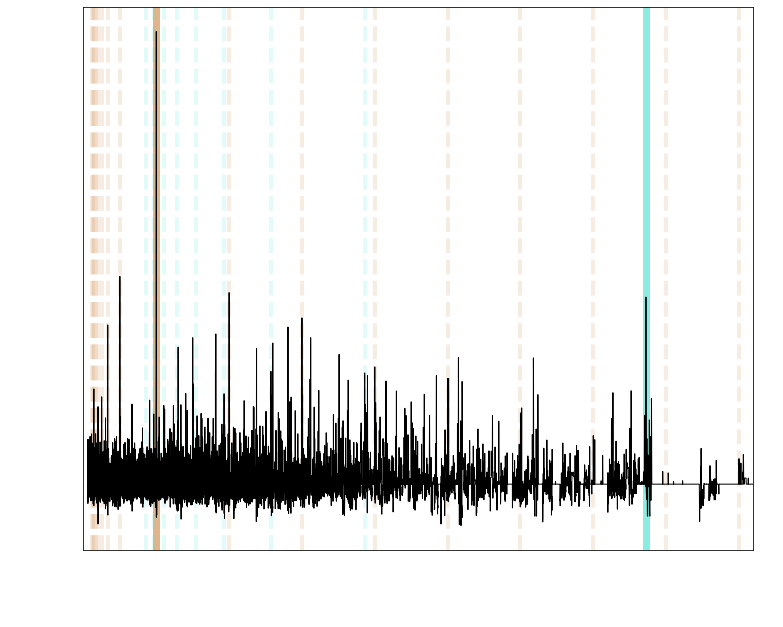

In [95]:
plt.figure(figsize = (12,10))
ax = plt.gca()
ax.axvline(results.period, alpha=0.6, lw=7, color = 'peru')
ax.axvline(results3.period, alpha=0.6, lw=7, color = 'turquoise')

plt.xlim(np.min(results.periods), np.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.15, lw=4, linestyle="dashed", color = 'peru')
    ax.axvline(results.period / n, alpha=0.15, lw=4, linestyle="dashed", color = 'peru')
for n in range(2, 10):
    ax.axvline(n*results3.period, alpha=0.15, lw=4, linestyle="dashed", color = 'turquoise')
    ax.axvline(results3.period / n, alpha=0.15, lw=4, linestyle="dashed", color = 'turquoise')

plt.ylabel(r'SDE', fontsize = 30, color = 'white')
plt.xlabel('Period (days)', fontsize = 30, color = 'white')
plt.plot(results.periods, results.power, color='black', lw=1)
# plt.plot(results3.periods, results3.power, color='teal', lw=0.5, alpha = 0.5)
plt.tick_params(labelsize=24, length = 9, color = 'white', labelcolor = 'white')

plt.xlim(0, 100);
plt.show()

# plt.figure()
# ax = plt.gca()
# ax.plot(time, flux, color = 'r' )

# ax.plot(time2, flux2, "k")
# ax.set_xlim(time2.min(), time2.max())
# ax.set_xlabel("Time (days)")
# ax.set_ylabel("Normalized flux");
# plt.show()


In [58]:
# intransit3 = transit_mask(time3, results3.period, 2.5*results3.duration, results3.T0)

# time4 = time3[~intransit3]
# flux4 =  flux3[~intransit3]

# model4 = transitleastsquares(time4, flux4)
# results4 = model4.power()
intransit4 = transit_mask(time4, results4.period, 2.5*results4.duration, results4.T0)


Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 61 durations
Searching 12277 data points, 94594 periods from 0.602 to 379.726 days
Using all 12 CPU threads


100%|████████████████████████████████████████| 94594/94594 periods | 15:07<00:00


Searching for best T0 for period 10.87726 days


100%|█████████████████████████████████████| 8832/8832 [00:03<00:00, 2570.19it/s]


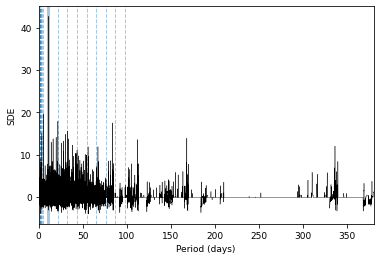

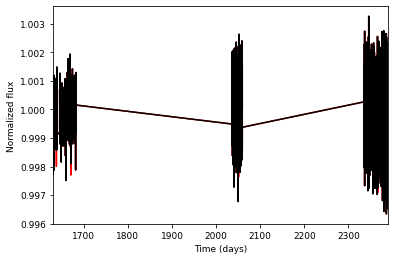

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 61 durations
Searching 12244 data points, 94594 periods from 0.602 to 379.726 days
Using all 12 CPU threads


100%|████████████████████████████████████████| 94594/94594 periods | 08:27<00:00


Searching for best T0 for period 10.87726 days


100%|███████████████████████████████████| 11773/11773 [00:02<00:00, 5618.86it/s]


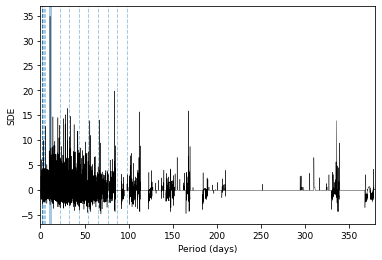

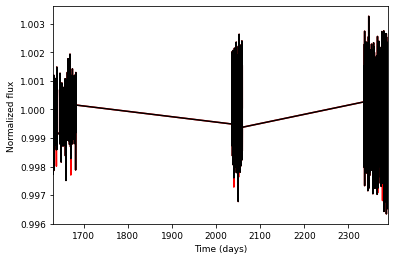

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 61 durations
Searching 12228 data points, 94594 periods from 0.602 to 379.726 days
Using all 12 CPU threads


100%|████████████████████████████████████████| 94594/94594 periods | 05:34<00:00


Searching for best T0 for period 10.87726 days


100%|███████████████████████████████████| 12228/12228 [00:02<00:00, 5595.68it/s]


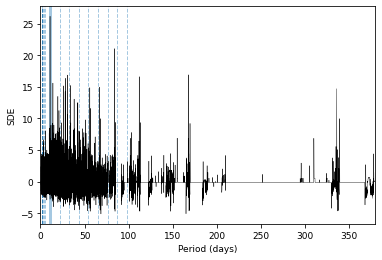

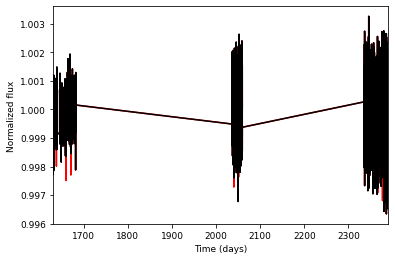

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 61 durations
Searching 12209 data points, 94594 periods from 0.602 to 379.726 days
Using all 12 CPU threads


100%|████████████████████████████████████████| 94594/94594 periods | 10:47<00:00


Searching for best T0 for period 84.00106 days


100%|███████████████████████████████████| 12209/12209 [00:03<00:00, 3941.06it/s]


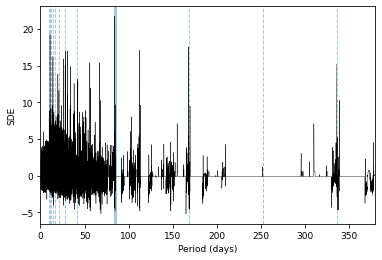

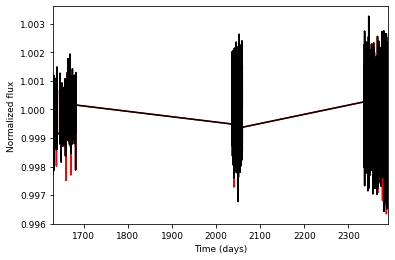

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 61 durations
Searching 12176 data points, 94594 periods from 0.602 to 379.726 days
Using all 12 CPU threads


100%|████████████████████████████████████████| 94594/94594 periods | 15:13<00:00


Searching for best T0 for period 10.87726 days


100%|███████████████████████████████████| 12176/12176 [00:04<00:00, 2856.00it/s]


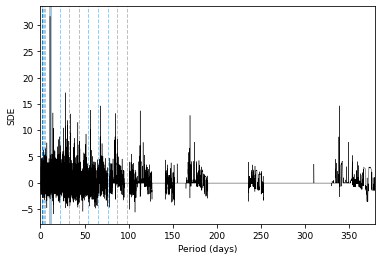

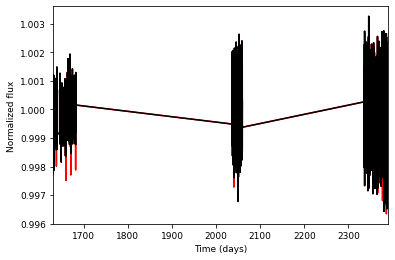

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 61 durations
Searching 12165 data points, 94594 periods from 0.602 to 379.726 days
Using all 12 CPU threads


100%|████████████████████████████████████████| 94594/94594 periods | 07:02<00:00


Searching for best T0 for period 10.87726 days


100%|███████████████████████████████████| 12165/12165 [00:03<00:00, 3301.46it/s]


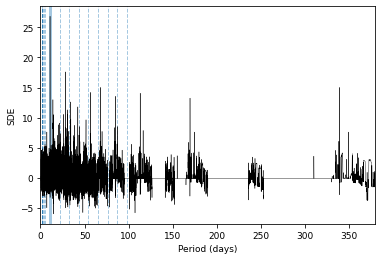

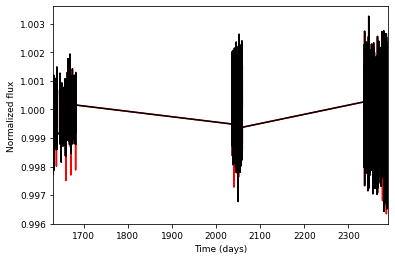

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 61 durations
Searching 12155 data points, 94594 periods from 0.602 to 379.726 days
Using all 12 CPU threads


100%|████████████████████████████████████████| 94594/94594 periods | 06:41<00:00


Searching for best T0 for period 28.27556 days


100%|███████████████████████████████████| 12155/12155 [00:03<00:00, 3610.91it/s]


done with multis!


(array([10.8772572, 10.8772572, 10.8772572, 84.0010637, 10.8772572,
        10.8772572]),
 array([1637.84356498, 1637.85760224, 1637.8240537 , 1630.34494153,
        1637.87153796, 1637.81314114]),
 array([0.01382246, 0.0103571 , 0.0085484 , 0.04937671, 0.00703475,
        0.00580859]),
 array([0.99836849, 0.9984306 , 0.99852441, 0.99846498, 0.99861723,
        0.99862422]),
 array([False, False,  True, ..., False, False, False]))

In [55]:
# using_TLS_to_find_periodic_signals(time, flux, ab, verbose = True, 
#                                        intransit = [],
#                                        periods = [], T0 = [], Tdur = [], depths = [], first=True)